In [1]:
cd ..

/home/sanjyot/bimi/robotics/av/working/latcom


# Import

In [2]:
from pathlib import Path
import pickle

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import tensorflow as tf

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from data import CommaData

In [5]:
orig_data_episode = '2016-01-30_t0_s0_eNone_b128_lr0.0001_ep10_w10_q20'
# time_shift_episode = '2016-01-30_t5_s5000_eNone_b64_lr0.0001_ep10_w10_q20'
h5_file = '2016-01-30--11-24-51.h5'

In [6]:
project_dir = Path.cwd()
res_dir =  project_dir / 'results'
mod_dir = project_dir / 'models'
img_data_dir = project_dir / 'dataset' / 'raw' / 'camera'
lbl_data_dir = project_dir / 'dataset' / 'raw' / 'log'

img_path = img_data_dir / h5_file
lbl_path = lbl_data_dir / h5_file
orig_data_hist = res_dir / orig_data_episode / 'history.pkl'
orig_data_model = mod_dir / f'{orig_data_episode}.h5'
orig_data_index = res_dir / orig_data_episode / 'indices.pkl'
# time_shift_hist = res_dir / time_shift_episode / 'history.pkl'
# time_shift_model = mod_dir / f'{time_shift_episode}.h5'
# time_shift_index = res_dir / time_shift_episode / 'indices.pkl'

# Training performance

In [7]:
def get_history(hist_file_path):
    with open(hist_file_path, 'rb') as f:
        df = pd.DataFrame(pickle.load(f))
        
    return (
        df
        [['mse', 'val_mse']]
        .reset_index()
        .rename(columns={'mse': 'train_mse', 'index': 'epoch'})
    )

def get_index(index_file_path):
    with open(index_file_path, 'rb') as f:
        idx = pickle.load(f)
    return idx

In [8]:
od = get_history(orig_data_hist).rename(columns={'train_mse': 'orig_train_mse', 'val_mse': 'orig_val_mse'})
# ts = get_history(time_shift_hist).rename(columns={'train_mse': 'shift_train_mse', 'val_mse': 'shift_val_mse'})
od_ix_dict = get_index(orig_data_index)
# ts_ix_dict = get_index(time_shift_index)
# hist = od.merge(ts, on='epoch')

In [9]:
# Check if both the experiments used the same train and valid data 
# assert set(od_ix_dict['train']) == set(ts_ix_dict['train'])
# assert set(od_ix_dict['valid']) == set(ts_ix_dict['valid'])

In [10]:
# cols = hist.columns.tolist()
# cols.remove('epoch')

In [11]:
# final_mse = hist[hist['epoch'] == hist['epoch'].max()].iloc[0,:].to_dict()
# ax = hist.plot(x='epoch', y=cols, kind='line', figsize=(12, 6), title='Loss/MSE with epoch', xlabel='Epoch')
# for i, col in enumerate(cols):
#     ax.annotate(f'{col}: {round(final_mse[col], 4)}', (7, 6-i))

{'epoch': 9.0, 'orig_train_mse': 3.7122354115126655e-05, 'orig_val_mse': 3.512445618980564e-05}


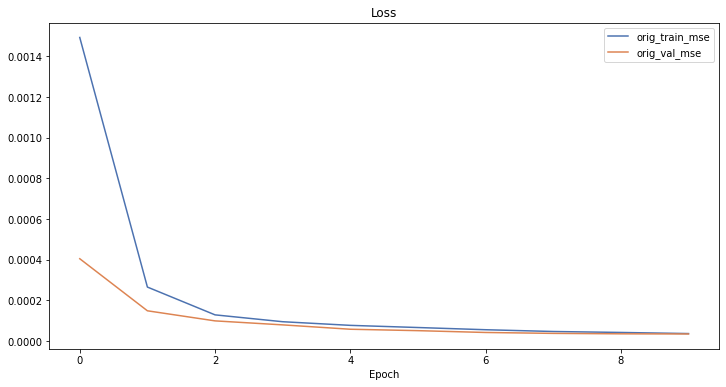

In [19]:
final_mse = od[od['epoch'] == od['epoch'].max()].iloc[0,:].to_dict()
ax = od.plot(x='epoch', y=['orig_train_mse', 'orig_val_mse'], kind='line', figsize=(12, 6), title='Loss', xlabel='Epoch')
print(final_mse)

# Baseline 1: Prediction = Mean

In [29]:
with h5py.File(lbl_path, 'r') as f:
    steerdt = f['steering_angle']
    valid_index = np.sort(od_ix_dict['valid'])
    y_valid = np.zeros_like(valid_index)
    for i, h5ix in enumerate(tqdm(valid_index)):
        y_valid[i] = steerdt[h5ix]

In [30]:
mean_model_mse = np.mean((y_valid - y_valid.mean())**2)
print(f'Mean model MSE: {round(mean_model_mse, 2)}')

Mean model MSE: 2963.8


# Baseline 2: Prediction = t - 50ms model

In [31]:
orig_index = od_ix_dict['valid']
orig_index = np.sort(orig_index)  # For h5 to work
t50_index = orig_index - 5  # 5 steps in past, effectively label from 50ms in past
assert t50_index.min() > 5

with h5py.File(lbl_path, 'r') as f:
    steerdt = f['steering_angle']
    
    # Load original steering angles
    y_valid = np.zeros_like(orig_index)
    for i, h5ix in enumerate(tqdm(orig_index)):
        y_valid[i] = steerdt[h5ix]
        
    # Load t-50ms steering angles
    t50 = np.zeros_like(orig_index)
    for i, h5ix in enumerate(tqdm(t50_index)):
        t50[i] = steerdt[h5ix]

In [32]:
t50_model_mse = np.mean((y_valid - t50)**2)
print(f'T-50ms model MSE: {round(t50_model_mse, 2)}')

T-50ms model MSE: 19.47


# Original data performance

## Original data model MSE

In [34]:
filepaths = {'img_path': img_path, 'lbl_path': lbl_path}
C = CommaData(filepaths)
train, valid = C.get_train_valid_datasets_from_indices(od_ix_dict)

od_model = tf.keras.models.load_model(orig_data_model)
y_pred = od_model.predict(valid, workers=10, max_queue_size=20)
y_pred = y_pred[:, 0]

In [39]:
y_pred_scaled = (y_pred * C.steer_shrink).astype(int)

In [40]:
orig_data_model_mse = np.median((y_valid - y_pred_scaled)**2)

In [42]:
print(f'Original data model MSE: {round(orig_data_model_mse, 2)}')

Original data model MSE: 484.0


## Distribution

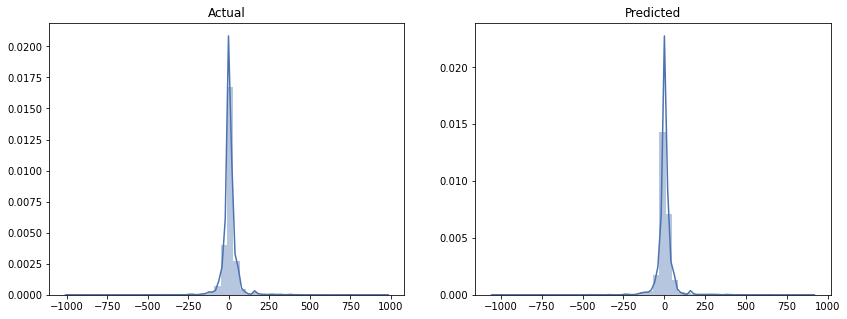

In [165]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
_ = sns.distplot(y_valid, label='Actual', ax=ax[0])
_ = sns.distplot(y_pred_scaled, label='Predicted', ax=ax[1])
ax[0].set_title('Actual')
_ = ax[1].set_title('Predicted')

# Timeshifted data performance

In [20]:
# filepaths = {'img_path': img_path, 'lbl_path': lbl_path}
# C5 = CommaData(filepaths, label_shift_steps=5)
# train, valid = C5.get_train_valid_datasets_from_indices(ts_ix_dict)

# ts_model = tf.keras.models.load_model(time_shift_model)
# y_pred_ts = ts_model.predict(valid, workers=10, max_queue_size=20)
# y_pred_ts = y_pred_ts[:, 0]

In [21]:
# y_pred_ts_scaled = (y_pred_ts * C5.steer_shrink).astype(int)

In [33]:
# time_shift_model_mse = np.median((y_valid - y_pred_ts_scaled)**2)

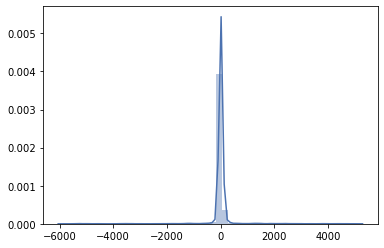

In [38]:
# _ = sns.distplot(y_pred_ts_scaled)

In [34]:
# print(f'Time shifted data model MSE: {round(time_shift_model_mse, 2)}')

Time shifted data model MSE: 1024.0


To do:
1. ~~Build visualization for checking the angles and images~~
2. ~~Check out the outliers and if it is ok to remove them~~
3. ~~Figure out the right rescaling of angles from visualization~~
4. Downsample 0 steering? Figure out how "dominant" is 0 steering and how frequent is a non-zero steering
5. Rescale, labels and train

# Visualize data

In [46]:
def show_image(img, true_steering, pred_steering=None, title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 16))
    ax.imshow(img)
    ax.tick_params(which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
    ax.annotate(f'Act: {round(true_steering, 1)}', (220, 30), color='white', size=16, family='monospace')
    if pred_steering:
        ax.annotate(f'Pre: {round(pred_steering, 1)}', (220, 43), color='white', size=16, family='monospace')
    if title:
        ax.set_title(title)

In [47]:
def get_data_from_ix(ix, img_file, lbl_file):
    steer = lbl_file['steering_angle'][ix]
    ptr = lbl_file['cam1_ptr'][ix]
    img = img_file['X'][ptr]
    img = np.moveaxis(img, 0, -1)
    return img, steer

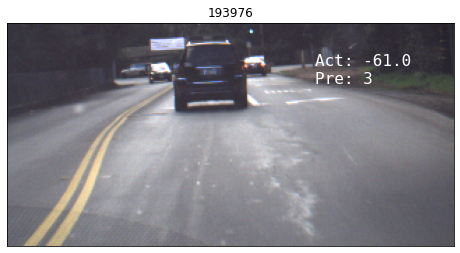

In [156]:
with h5py.File(img_path, 'r') as img_file:
    with h5py.File(lbl_path, 'r') as lbl_file:
        size = len(lbl_file['steering_angle'])
        
        
        true_steer = 0
        while true_steer is not None and true_steer > -60.0:
            lbl_ix = np.random.choice(orig_index)
            steer_ix_in_valid = np.where(orig_index == lbl_ix)[0][0]
    #         print(steer_ix_in_valid)
            pred_steer = y_pred_scaled[steer_ix_in_valid]
#             print(pred_steer)
            img, true_steer = get_data_from_ix(lbl_ix, img_file, lbl_file)
        show_image(img, true_steer, pred_steer, title=lbl_ix)